<a href="https://colab.research.google.com/github/victorhss21/Estudos_CD/blob/main/Matching_Score_CL_with_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 00. Gerando conjunto de dados sintético

In [ ]:
import pandas as pd
import numpy as np
import random

# Configuração para reprodutibilidade
np.random.seed(42)

def gerar_base_sintetica(n_registros=500000):
    print(f"Iniciando geração de {n_registros} registros...")

    # --- 1. Geração de CNPJs Únicos ---
    # Geramos números aleatórios únicos para garantir chave primária
    # Intervalo suficiente para cobrir n_registros
    print("Gerando CNPJs...")
    raizes = np.random.choice(range(10000000, 99999999), size=n_registros, replace=False)
    cnpjs = [f"{r}" for r in raizes]

    # --- 2. Definição de Categorias e Distribuições ---

    # Portes (Segmento de Cliente)
    portes = ['MEI', 'LOWER', 'MIDDLE', 'UPPER']
    p_portes = [0.40, 0.30, 0.20, 0.10] # Maioria é pequena empresa

    # Ramos
    ramos = ['Varejo', 'Comercio', 'Educacao', 'Tecnologia']

    # Modelos
    modelos = ['B2C', 'B2B', 'B2G']

    # Estados (Peso aproximado por relevância econômica)
    estados = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'PE', 'CE', 'GO', 'ES', 'MT', 'MS', 'DF']
    p_estados = [0.35, 0.10, 0.10, 0.08, 0.07, 0.05, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02]
    # Normalizar para garantir soma 1.0
    p_estados = np.array(p_estados) / np.sum(p_estados)

    # --- 3. Atribuição Vetorizada das Características Básicas ---
    print("Atribuindo características...")

    df = pd.DataFrame({
        'cnpj': cnpjs,
        'cnpj_raiz': raizes,
        'porte': np.random.choice(portes, n_registros, p=p_portes),
        'ramo': np.random.choice(ramos, n_registros),
        'modelo_operacao': np.random.choice(modelos, n_registros, p=[0.5, 0.4, 0.1]),
        'estado': np.random.choice(estados, n_registros, p=p_estados),
        # Definindo 'segmento_analise' (Novo vs Outro)
        # Premissa: 'Novo' segmento tende a ser mais Tech e Varejo Digital
        'segmento_analise': np.random.choice(['novo', 'outro'], n_registros, p=[0.2, 0.8])
    })

    # --- 4. Geração Coerente de Valores Numéricos (Lógica de Negócio) ---
    print("Calculando métricas financeiras coerentes...")

    # Função auxiliar para gerar valores baseados no porte
    def get_vol_recebimento(porte):
        if porte == 'MEI': return np.random.uniform(1000, 6750)
        elif porte == 'LOWER': return np.random.uniform(5000, 50000)
        elif porte == 'MIDDLE': return np.random.uniform(40000, 300000)
        else: return np.random.uniform(200000, 800000) # UPPER

    # Vetorização usando numpy select/piecewise para performance
    conditions_vol = [
        df['porte'] == 'MEI',
        df['porte'] == 'LOWER',
        df['porte'] == 'MIDDLE',
        df['porte'] == 'UPPER'
    ]

    # Gerando vetores aleatórios para cada condição
    vals_mei = np.random.uniform(1000, 6750, n_registros)
    vals_lower = np.random.uniform(5000, 50000, n_registros)
    vals_middle = np.random.uniform(40000, 300000, n_registros)
    vals_upper = np.random.uniform(200000, 800000, n_registros)

    df['vol_recebimento_total'] = np.select(conditions_vol, [vals_mei, vals_lower, vals_middle, vals_upper])

    # Ajuste fino: Tecnologia e Varejo tendem a faturar um pouco mais dentro da faixa
    mask_boost = df['ramo'].isin(['Tecnologia', 'Varejo'])
    df.loc[mask_boost, 'vol_recebimento_total'] *= np.random.uniform(1.0, 1.2, mask_boost.sum())

    # Garantir teto máximo do enunciado
    df['vol_recebimento_total'] = df['vol_recebimento_total'].clip(1000, 800000)

    # --- 5. Geração de Transações Digitais (Coerência com Ramo e Modelo) ---
    # Base: Quanto maior o faturamento, mais transações, MAS depende do modelo
    # B2C Varejo = Muitas transações pequenas
    # B2B Consultoria = Poucas transações grandes

    base_transacoes = np.random.randint(5, 1000, n_registros)

    # Fatores multiplicadores
    fator_modelo = np.select(
        [df['modelo_operacao'] == 'B2C', df['modelo_operacao'] == 'B2B', df['modelo_operacao'] == 'B2G'],
        [1.5, 0.6, 0.4] # B2C transaciona mais vezes
    )

    fator_ramo = np.select(
        [df['ramo'] == 'Tecnologia', df['ramo'] == 'Varejo', df['ramo'] == 'Educacao'],
        [1.8, 1.5, 0.8], default=1.0 # Tech e Varejo são mais digitais
    )

    # Aplica fatores
    df['qtd_transacoes_canais_digitais'] = base_transacoes * fator_modelo * fator_ramo

    # Correlação com Faturamento (quem ganha mais, geralmente transaciona mais)
    # Normaliza faturamento (0 a 1) e usa como boost
    norm_fat = (df['vol_recebimento_total'] - 1000) / (800000 - 1000)
    df['qtd_transacoes_canais_digitais'] += (norm_fat * 200)

    # Clip final para respeitar limites do enunciado e converter para int
    df['qtd_transacoes_canais_digitais'] = df['qtd_transacoes_canais_digitais'].clip(5, 1000).astype(int)

    # --- 6. Otimização de Tipos de Dados ---
    print("Otimizando memória...")
    df['cnpj'] = df['cnpj'].astype('string')
    df['cnpj_raiz'] = df['cnpj_raiz'].astype('uint32') # 8 digitos cabe em uint32
    df['porte'] = df['porte'].astype('category')
    df['ramo'] = df['ramo'].astype('category')
    df['modelo_operacao'] = df['modelo_operacao'].astype('category')
    df['estado'] = df['estado'].astype('category')
    df['segmento_analise'] = df['segmento_analise'].astype('category')
    df['qtd_transacoes_canais_digitais'] = df['qtd_transacoes_canais_digitais'].astype('uint16') # max 1000 cabe em uint16
    df['vol_recebimento_total'] = df['vol_recebimento_total'].astype('float32')

    return df

# --- Execução ---
df_final = gerar_base_sintetica(500000)

# Validações Rápidas
print("\n--- Resumo da Base ---")
print(df_final.info())
print("\n--- Amostra dos Dados ---")
print(df_final.head())

print("\n--- Coerência: Média de Faturamento por Porte ---")
print(df_final.groupby('porte', observed=True)['vol_recebimento_total'].mean().sort_values())

print("\n--- Coerência: Média de Transações por Modelo ---")
print(df_final.groupby('modelo_operacao', observed=True)['qtd_transacoes_canais_digitais'].mean().sort_values())

# # Exportar (Opcional)
# df_final.to_parquet('base_clientes_sintetica.parquet')

Iniciando geração de 500000 registros...
Gerando CNPJs...
Atribuindo características...
Calculando métricas financeiras coerentes...
Otimizando memória...

--- Resumo da Base ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   cnpj                            500000 non-null  string  
 1   cnpj_raiz                       500000 non-null  uint32  
 2   porte                           500000 non-null  category
 3   ramo                            500000 non-null  category
 4   modelo_operacao                 500000 non-null  category
 5   estado                          500000 non-null  category
 6   segmento_analise                500000 non-null  category
 7   vol_recebimento_total           500000 non-null  float32 
 8   qtd_transacoes_canais_digitais  500000 non-null  uint16  
dtypes: category(5

## 01. Propensity Score Matching

### 01.1. Abordagem A: Classificador Probabilístivo + KNN

Aplicando calibração via método: ISOTONIC
Processando Logistic Regression...
Processando XGBoost...
Processando LightGBM...


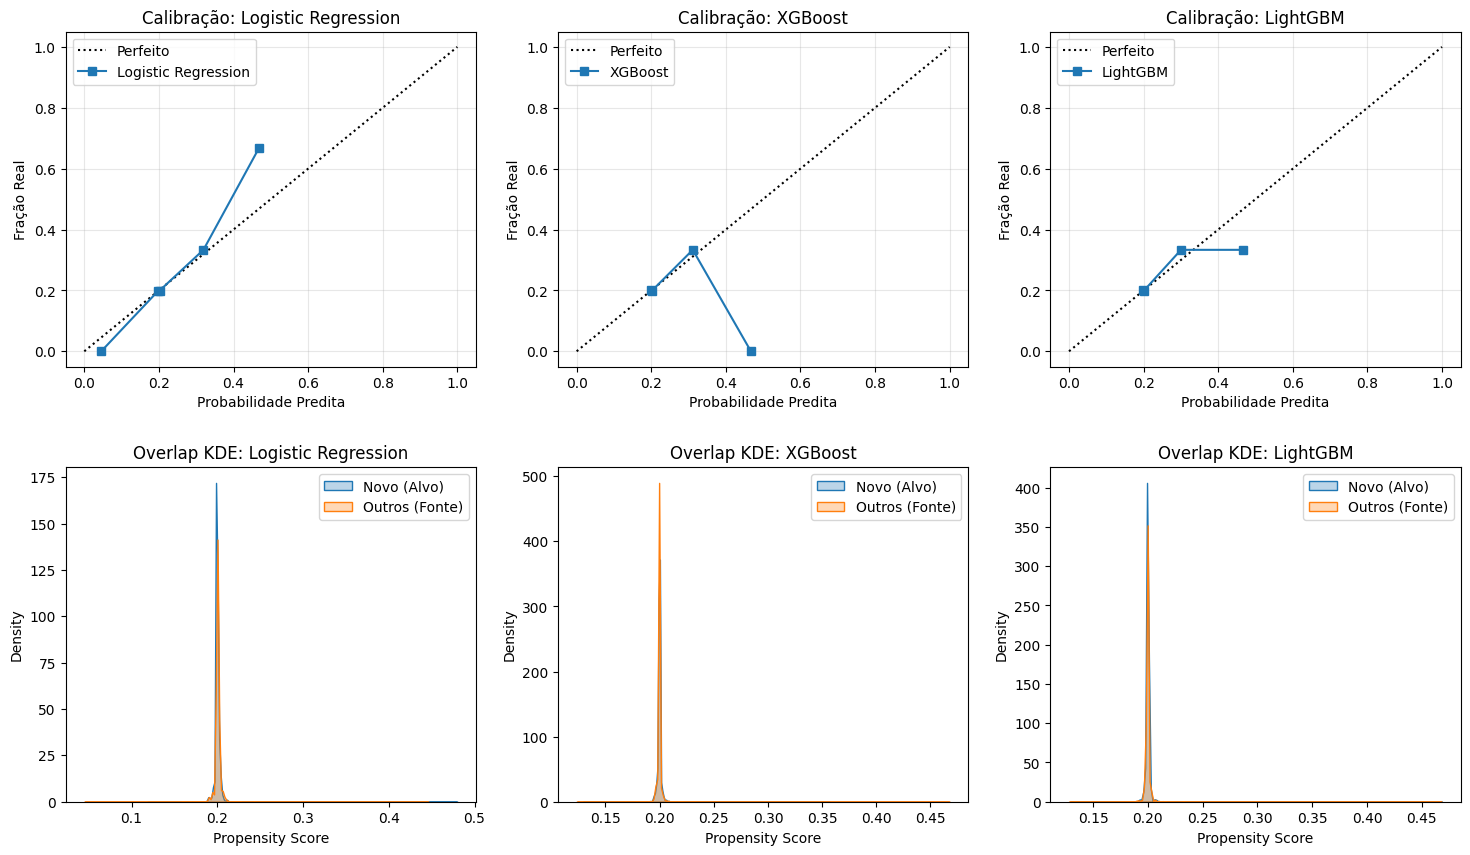

Caliper definido (distância máx): 0.0028
Realizando Matching Sem Reposição com Caliper...
Clientes Novos descartados (sem par válido/disponível): 95166 (95.4%)


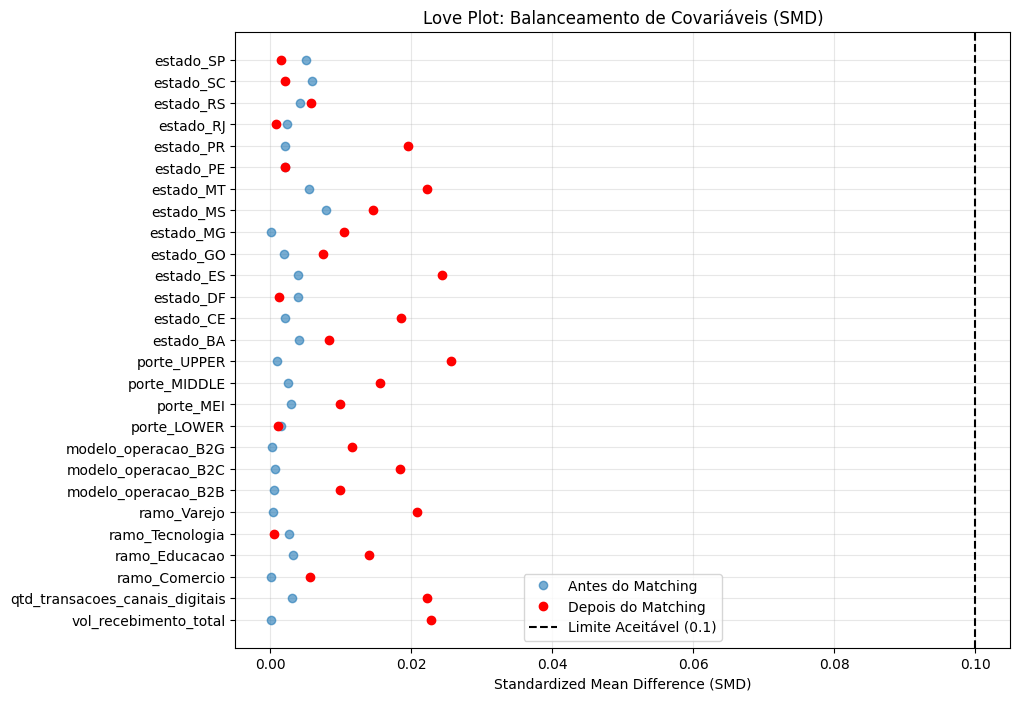


=== Exemplo de Pares Encontrados ===
  CNPJ_Novo  Score_Novo CNPJ_Benchmark  Score_Benchmark  Meta_Crescimento
0  90809057    0.200444       69667305         0.200444          0.191095
1  35622726    0.200019       38694912         0.200019          0.114897
2  64990711    0.199770       60972276         0.199770          0.120031
3  85531921    0.200426       15305101         0.200426          0.159323
4  81228547    0.199425       67618924         0.199425          0.174124

=== Resultado da Projeção (LightGBM) ===
Média de Crescimento Histórico do Grupo Benchmark: 15.00%
Meta de Crescimento Ajustada: 14.95%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ==============================================================================
# 1. ADAPTAÇÃO DO DATASET GERADO (df_final) PARA O FLUXO DE MATCHING
# ==============================================================================

# Assumindo que 'df_final' já foi gerado pelo código anterior
df = df_final.copy()

# Criar target binário: 1 se 'novo', 0 se 'outro'
df['segmento_novo'] = (df['segmento_analise'] == 'novo').astype(int)

# Simulação da variável de crescimento
np.random.seed(42)
mask_benchmark = df['segmento_novo'] == 0
n_bench = mask_benchmark.sum()
df.loc[mask_benchmark, 'crescimento_anual_real'] = np.random.normal(0.15, 0.05, n_bench)

# ==============================================================================
# 2. PREPARAÇÃO DE FEATURES
# ==============================================================================

cat_features = ['ramo', 'modelo_operacao', 'porte', 'estado']
num_features = ['vol_recebimento_total', 'qtd_transacoes_canais_digitais']

X = df[cat_features + num_features]
y = df['segmento_novo']

# Preprocessor base (será usado para LogReg)
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Preprocessor para Árvores (XGB/LGBM lidam bem com numéricas sem scale, apenas OneHot simples)
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features), # Árvores não precisam de StandardScaler
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# ==============================================================================
# 3. DEFINIÇÃO DOS 3 MODELOS
# ==============================================================================

# Modelo 1: Regressão Logística
model_logreg = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Modelo 2: XGBoost
model_xgboost = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(scale_pos_weight=4, random_state=42, eval_metric='logloss', n_jobs=-1,
                                 max_depth=5, learning_rate=0.1, n_estimators=10))
])

# Modelo 3: LightGBM
model_lgbm = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1,
                                  max_depth=5, learning_rate=0.1, n_estimators=10))
])

models = {
    'Logistic Regression': model_logreg,
    'XGBoost': model_xgboost,
    'LightGBM': model_lgbm
}

# ==============================================================================
# 4. GERAÇÃO DE SCORES, CALIBRAÇÃO E PLOTAGEM
# ==============================================================================

calibration_method = 'isotonic' if len(df) > 1000 else 'sigmoid'
print(f"Aplicando calibração via método: {calibration_method.upper()}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário para armazenar scores finais de cada modelo
scores_results = {}

# Configuração dos Subplots: 2 Linhas (Calibração, KDE), 3 Colunas (Modelos)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for i, (name, model) in enumerate(models.items()):
    print(f"Processando {name}...")

    # 1. Calibrar e Prever via Cross-Validation
    calibrated_model_cv = CalibratedClassifierCV(estimator=model, method=calibration_method, cv=3)
    y_proba_cv = cross_val_predict(calibrated_model_cv, X, y, cv=cv, method='predict_proba', n_jobs=-1)

    # Guardar score
    scores_results[name] = y_proba_cv[:, 1]

    # 2. Plot Reliability Diagram (Linha 0, Coluna i)
    prob_true, prob_pred = calibration_curve(y, scores_results[name], n_bins=10)
    ax_calib = axes[0, i]
    ax_calib.plot([0, 1], [0, 1], "k:", label="Perfeito")
    ax_calib.plot(prob_pred, prob_true, "s-", label=f"{name}")
    ax_calib.set_title(f"Calibração: {name}")
    ax_calib.set_xlabel("Probabilidade Predita")
    ax_calib.set_ylabel("Fração Real")
    ax_calib.legend()
    ax_calib.grid(True, alpha=0.3)

    # 3. Plot KDE Overlap (Linha 1, Coluna i)
    ax_kde = axes[1, i]
    sns.kdeplot(scores_results[name][y==1], label='Novo (Alvo)', fill=True, alpha=0.3, ax=ax_kde)
    sns.kdeplot(scores_results[name][y==0], label='Outros (Fonte)', fill=True, alpha=0.3, ax=ax_kde)
    ax_kde.set_title(f"Overlap KDE: {name}")
    ax_kde.set_xlabel("Propensity Score")
    ax_kde.legend()

plt.show()

# ==============================================================================
# 5. SELEÇÃO DO MELHOR SCORE E MATCHING COM MELHORIAS 2 E 3
# ==============================================================================

# Escolha qual score usar para o matching final (aqui fixei LightGBM)
df['propensity_score'] = scores_results['LightGBM']

# Converter para Logit
eps = 1e-6
df['propensity_score_clipped'] = df['propensity_score'].clip(eps, 1 - eps)
df['propensity_logit'] = np.log(df['propensity_score_clipped'] / (1 - df['propensity_score_clipped']))

# Preparar DataFrames
df_treatment = df[df['segmento_novo'] == 1].copy().reset_index(drop=True)
df_control = df[df['segmento_novo'] == 0].copy().reset_index(drop=True)

# --- MELHORIA 3: MATCHING COM CALIPER E SEM REPOSIÇÃO ---
# Definir Caliper (0.2 desvios padrão do score Logit)
std_logit = df['propensity_logit'].std()
caliper = 0.2 * std_logit
print(f"Caliper definido (distância máx): {caliper:.4f}")

print("Realizando Matching Sem Reposição com Caliper...")
# Para sem reposição exata em Python de forma eficiente, a melhor estratégia é iterativa ou usar otimização linear.
# Como sklearn NearestNeighbors não suporta 'sem reposição' nativo, implementamos uma heurística gulosa eficiente:
# 1. Encontrar vizinhos candidatos.
# 2. Ordenar por distância.
# 3. Atribuir match se o controle não foi usado ainda.

# Busca inicial de múltiplos vizinhos (ex: 10) para ter candidatos caso o 1º já esteja ocupado
knn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', n_jobs=-1)
knn.fit(df_control[['propensity_logit']])

distances, indices = knn.kneighbors(df_treatment[['propensity_logit']])

# Estruturas para controle de uso
control_used = set()
matches = []

# Iterar sobre os tratamentos (pode ser ordenado por 'dificuldade de match' se desejar refinar, mas aleatório ou sequencial é padrão simples)
# Aqui vamos iterar sequencialmente
for i in range(len(df_treatment)):
    # Candidatos para o tratamento i
    candidates_idx = indices[i]
    candidates_dist = distances[i]

    match_found = None

    for neighbor_idx, dist in zip(candidates_idx, candidates_dist):
        # Verificar Caliper
        if dist > caliper:
            break # Como está ordenado, se passou do caliper, os próximos também passarão

        # Verificar se já foi usado (Sem Reposição)
        if neighbor_idx not in control_used:
            match_found = neighbor_idx
            control_used.add(neighbor_idx)
            break

    if match_found is not None:
        matches.append({
            'idx_treatment': i,
            'idx_control': match_found,
            'distance': dist
        })

# Construir DataFrames Finais dos Matches Válidos
matches_df = pd.DataFrame(matches)
num_discarded = len(df_treatment) - len(matches_df)
print(f"Clientes Novos descartados (sem par válido/disponível): {num_discarded} ({num_discarded/len(df_treatment):.1%})")

df_treatment_matched = df_treatment.iloc[matches_df['idx_treatment']].reset_index(drop=True)
df_control_matched = df_control.iloc[matches_df['idx_control']].reset_index(drop=True)

resultado_matching = pd.DataFrame({
    'CNPJ_Novo': df_treatment_matched['cnpj'].values,
    'Score_Novo': df_treatment_matched['propensity_score'].values,
    'CNPJ_Benchmark': df_control_matched['cnpj'].values,
    'Score_Benchmark': df_control_matched['propensity_score'].values,
    'Meta_Crescimento': df_control_matched['crescimento_anual_real'].values
})

# ==============================================================================
# MELHORIA 2: DIAGNÓSTICO DE BALANCEAMENTO (SMD) - LOVE PLOT
# ==============================================================================

def calculate_smd(df1, df2, columns):
    smd_data = []
    for col in columns:
        mu1, mu2 = df1[col].mean(), df2[col].mean()
        var1, var2 = df1[col].var(), df2[col].var()
        denom = np.sqrt((var1 + var2) / 2)
        if denom == 0: denom = 1e-9
        smd = abs(mu1 - mu2) / denom
        smd_data.append({'Variable': col, 'SMD': smd})
    return pd.DataFrame(smd_data)

# Preparar dados encoded para cálculo SMD
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Fit na base total para consistência
encoder.fit(df[cat_features])
encoded_cols = list(encoder.get_feature_names_out(cat_features))
all_cols_smd = num_features + encoded_cols

# Função auxiliar para transformar
def transform_for_smd(df_input):
    cats = encoder.transform(df_input[cat_features])
    nums = df_input[num_features].values
    data = np.hstack([nums, cats])
    return pd.DataFrame(data, columns=all_cols_smd)

# Antes do Matching (tratamento vs controle total)
df_treat_smd_pre = transform_for_smd(df_treatment)
df_ctrl_smd_pre = transform_for_smd(df_control)
smd_before = calculate_smd(df_treat_smd_pre, df_ctrl_smd_pre, all_cols_smd)

# Depois do Matching (tratamento matched vs controle matched)
df_treat_smd_post = transform_for_smd(df_treatment_matched)
df_ctrl_smd_post = transform_for_smd(df_control_matched)
smd_after = calculate_smd(df_treat_smd_post, df_ctrl_smd_post, all_cols_smd)

# Plot Love Plot
plt.figure(figsize=(10, 8))
plt.plot(smd_before['SMD'], smd_before['Variable'], 'o', label='Antes do Matching', alpha=0.6)
plt.plot(smd_after['SMD'], smd_after['Variable'], 'o', label='Depois do Matching', color='red')
plt.axvline(0.1, color='black', linestyle='--', label='Limite Aceitável (0.1)')
plt.title('Love Plot: Balanceamento de Covariáveis (SMD)')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# 6. ANÁLISE FINAL
# ==============================================================================

print("\n=== Exemplo de Pares Encontrados ===")
print(resultado_matching.head())

media_crescimento_projetada = resultado_matching['Meta_Crescimento'].mean()
print(f"\n=== Resultado da Projeção (LightGBM) ===")
print(f"Média de Crescimento Histórico do Grupo Benchmark: {df_control['crescimento_anual_real'].mean():.2%}")
print(f"Meta de Crescimento Ajustada: {media_crescimento_projetada:.2%}")

In [ ]:
df_pares[['cnpj_treat', 'cnpj_ctrl', 'ramo_treat', 'ramo_ctrl', 'propensity_score_treat', 'propensity_score_ctrl']]

,cnpj_treat,cnpj_ctrl,ramo_treat,ramo_ctrl,propensity_score_treat,propensity_score_ctrl
0,90809057,62169870,Comercio,Varejo,0.200597,0.200597
1,35622726,38326685,Tecnologia,Varejo,0.200657,0.200657
2,64990711,30002961,Tecnologia,Tecnologia,0.199924,0.199924
3,85531921,69128906,Tecnologia,Varejo,0.200680,0.200680
4,81228547,67699333,Varejo,Tecnologia,0.197821,0.197821
...,...,...,...,...,...,...
3655,85222691,70262391,Tecnologia,Tecnologia,0.239441,0.239123
3656,21472427,59971864,Educacao,Educacao,0.157489,0.157229
3657,81014546,48860913,Educacao,Educacao,0.149784,0.149504
3658,92872184,85013669,Educacao,Educacao,0.158801,0.159151
